In [1]:
#%%capture
#!pip install db-dtypes
#!pip install keras
#!pip install tensorflow

In [2]:
%%capture
%logstop
%logstart -t -r -q ipython_command_log.py global

#- IRONHACKS RESEARCH TRACKING CODE
#----------------------------------
# The following code is used to help our research team understand how you 
# our notebook environment. We do not collect any personal information with
# the following code, it is used to measure when and how often you work on
# your submission files.

import os
from datetime import datetime
import IPython.core.history as history

ha = history.HistoryAccessor()
ha_tail = ha.get_tail(1)
ha_cmd = next(ha_tail)
session_id = str(ha_cmd[0])
command_id = str(ha_cmd[1])
timestamp = datetime.utcnow().isoformat()
history_line = ','.join([session_id, command_id, timestamp]) + '\n'
logfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')
logfile.write(history_line)
logfile.close()

In [1]:
%%capture
import pandas as pd
import numpy as np
import os
#from google.cloud import bigquery
#from google.oauth2 import service_account
#from google.cloud.bigquery import magics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNetCV
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
import joblib
from joblib import Parallel, delayed
from scipy import stats
from sklearn.ensemble import IsolationForest

### Retrieve Data, EDA and Data Cleaning

In [4]:
#BIGQUERY_PROJECT = 'ironhacks-data'
#bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
#query_main = """
#SELECT *
#FROM `ironhacks-data.ironhacks_competition.unemployment_data`
#"""
#
#query_job = bigquery_client.query(query_main)
#unemployment_data = query_job.to_dataframe()

In [6]:
#query = """
#SELECT *
#FROM `ironhacks-data.ironhacks_competition.wage_data`
#"""
#
#query_job = bigquery_client.query(query)
#wage_data = query_job.to_dataframe()

In [7]:
#query_pred = """
#SELECT * 
#FROM `ironhacks-data.ironhacks_competition.prediction_list`
#"""
#
#query_job = bigquery_client.query(query_pred)
#prediction_list = query_job.to_dataframe()

In [8]:
#print(unemployment_data.info())
#print(wage_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16833 entries, 0 to 16832
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uu_id                   16833 non-null  object
 1   timeperiod              16833 non-null  Int64 
 2   week_number             16833 non-null  Int64 
 3   countyfips              16833 non-null  Int64 
 4   tract                   16833 non-null  Int64 
 5   tract_name              16833 non-null  object
 6   total_claims            16833 non-null  Int64 
 7   edu_8th_or_less         13748 non-null  Int64 
 8   edu_grades_9_11         5942 non-null   Int64 
 9   edu_hs_grad_equiv       6036 non-null   Int64 
 10  edu_post_hs             3246 non-null   Int64 
 11  edu_unknown             12031 non-null  Int64 
 12  top_category_employer1  16833 non-null  object
 13  top_category_employer2  16833 non-null  object
 14  top_category_employer3  16833 non-null  object
 15  ge

In [9]:
# check shape of both frames to see if they are joinable
#print('Unemployment df size:', unemployment_data.shape)
#print('Wage df size:', wage_data.shape)

Unemployment df size: (16833, 25)
Wage df size: (525, 5)


##### Small EDA to validate data contents for additional preprocessing

In [10]:
#unemployment_data.isnull().sum() / len(unemployment_data) * 100

uu_id                      0.000000
timeperiod                 0.000000
week_number                0.000000
countyfips                 0.000000
tract                      0.000000
tract_name                 0.000000
total_claims               0.000000
edu_8th_or_less           18.327096
edu_grades_9_11           64.700291
edu_hs_grad_equiv         64.141864
edu_post_hs               80.716450
edu_unknown               28.527298
top_category_employer1     0.000000
top_category_employer2     0.000000
top_category_employer3     0.000000
gender_female             77.217371
gender_male               76.647062
gender_na                  5.732787
race_amerindian            9.196222
race_asian                11.251708
race_black                57.678370
race_noanswer             40.064160
race_hawaiiannative        2.417870
race_other                52.028753
race_white                62.026971
dtype: float64

In [11]:
#wage_data.isnull().sum() / len(wage_data) * 100

uu_id           0.0
countyfips      0.0
tract           0.0
tract_name      0.0
average_wage    0.0
dtype: float64

I've concluded that imputing the 'NA' values in the data with 0s is a temporary solution to dealing with this dataset, until I can figure out a better way to engineer these features correctly. 
It appears the values for each variable are the summation of each respondent that meets variable criterion, that cannot exceed the value specified under the 'total_claims' column. I will use this column as a beacon. 

It is likely that questions regarding race were not answered fully or were skipped during collection - so expect some discrepancies.

In [12]:
# replace values with 0
#clean_unemploymentDf = unemployment_data.copy()
#clean_unemploymentDf.fillna(0, inplace=True)
#clean_unemploymentDf

uu_id  timeperiod  week_number  countyfips  \
0      f013068de98db1470bd986137a0c6d23    20220416           16       18003   
1      21957d5517323845818d87623589e1ba    20220319           12       18089   
2      6a5609f385912113b6f1014b958ed748    20220326           13       18089   
3      46b2882ec4c373527ec33f7bd4f1388d    20220716           29       18089   
4      37495d17e82f7df326bfc2c4c090f7b7    20220409           15       18089   
...                                 ...         ...          ...         ...   
16828  f35320206f3dd1ffc411e4ac127caf92    20220618           25       18163   
16829  f35320206f3dd1ffc411e4ac127caf92    20220827           35       18163   
16830  f35320206f3dd1ffc411e4ac127caf92    20220827           35       18163   
16831  bbcb018f0e5e49e13636f6e78ce9f60f    20220326           13       18163   
16832  bbcb018f0e5e49e13636f6e78ce9f60f    20220416           16       18163   

       tract                                        tract_name  total_claims  \
0        900             Census Tract 9, Allen County, Indiana            22   
1      10400            Census Tract 104, Lake County, Indiana           111   
2      11500            Census Tract 115, Lake County, Indiana            39   
3      20700            Census Tract 207, Lake County, Indiana            14   
4      21900            Census Tract 219, Lake County, Indiana           155   
...      ...                                               ...           ...   
16828   3804   Census Tract 38.04, Vanderburgh County, Indiana            21   
16829   3804   Census Tract 38.04, Vanderburgh County, Indiana            22   
16830   3804   Census Tract 38.04, Vanderburgh County, Indiana            22   
16831  10203  Census Tract 102.03, Vanderburgh County, Indiana            53   
16832  10203  Census Tract 102.03, Vanderburgh County, Indiana            24   

       edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  ...  \
0                    0                0                 14  ...   
1                    0                0                108  ...   
2                    0                0                  0  ...   
3                    0                0                  0  ...   
4                    0                0                 69  ...   
...                ...              ...                ...  ...   
16828                0                0                  0  ...   
16829                0                0                 13  ...   
16830                0                0                 13  ...   
16831                0                0                 48  ...   
16832                0                0                 18  ...   

       gender_female  gender_male gender_na race_amerindian race_asian  \
0                  0            0         0               0          0   
1                 76           35         0               0          0   
2                  0            0         0               0          0   
3                  0            0         0               0          0   
4                 90           65         0               0          0   
...              ...          ...       ...             ...        ...   
16828              0            0         0               0          0   
16829              0            0         0               0          0   
16830              0            0         0               0          0   
16831              0            0         0               0          0   
16832             11           13         0               0          0   

       race_black  race_noanswer  race_hawaiiannative  race_other  race_white  
0              11              0                    0           0           0  
1               0              0                    0           0           0  
2              39              0                    0           0           0  
3              10              0                    0           0           0  
4             135 

In [13]:
#clean_unemploymentDf.isnull().sum() #check

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
dtype: int64

In [14]:
#%%capture
#unemp_dupl = clean_unemploymentDf[clean_unemploymentDf.duplicated()]
#print('Duplicate rows: ', unemp_dupl)
## ignore duplicates - different time periods

/tmp/ipykernel_407/3330649336.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = clean_unemploymentDf.corr()


<AxesSubplot: >

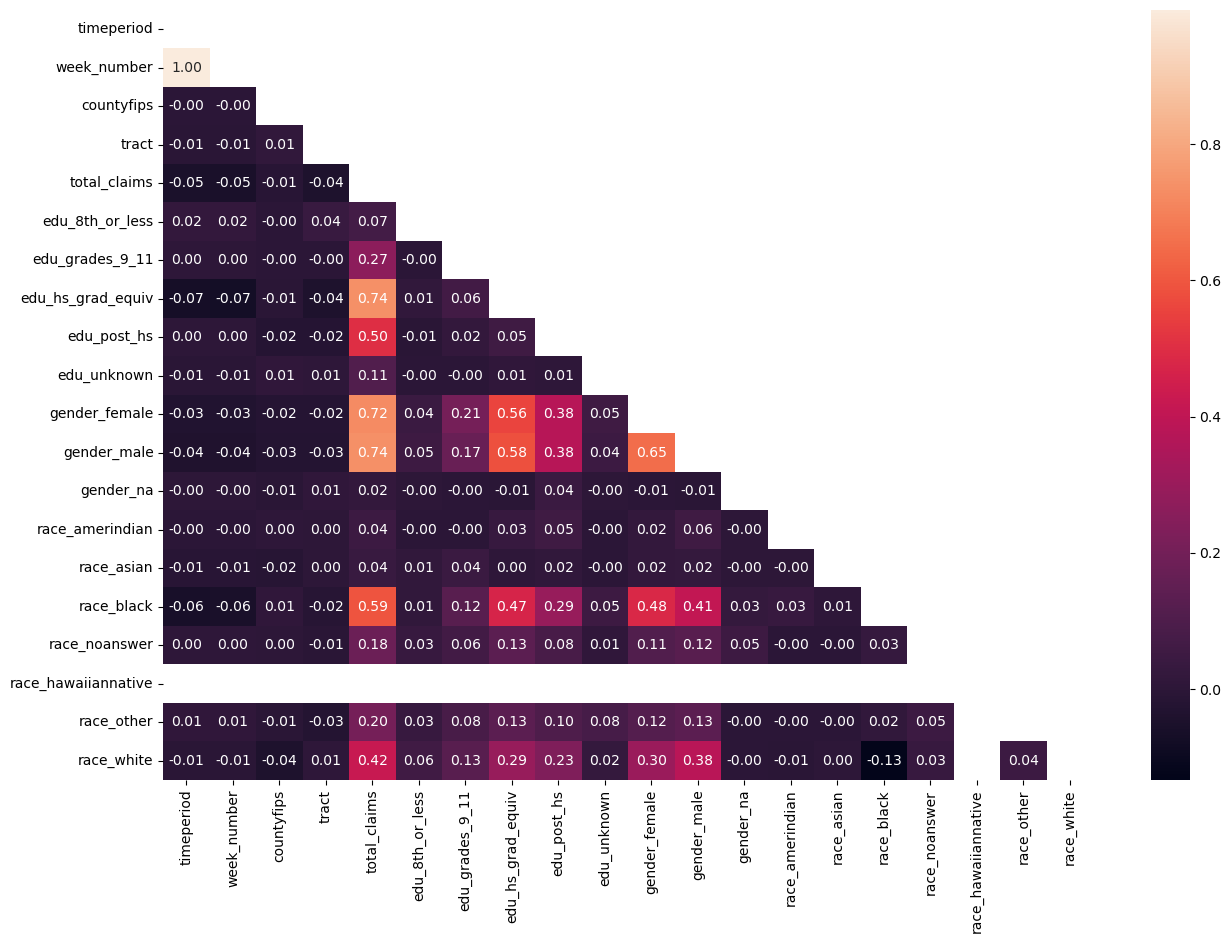

In [15]:
# check correlation
#correlation = clean_unemploymentDf.corr()
#mask = np.triu(np.ones_like(correlation, dtype=bool))
#plt.figure(figsize=(15,10))
#sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [16]:
# check wage information
#wage_data[wage_data['average_wage'].isnull()] # there's 3 nulls here - might as well drop them and use this tract to attempt to join the datasets together; or impute with mean

Empty DataFrame
Columns: [uu_id, countyfips, tract, tract_name, average_wage]
Index: []

In [17]:
#wage_data.dropna(axis=0, inplace=True)
#wage_data['average_wage'].fillna(wage_data['average_wage'].mean(), inplace=True)
#wage_data.isnull().sum()

uu_id           0
countyfips      0
tract           0
tract_name      0
average_wage    0
dtype: int64

In [18]:
#wage_dupl = wage_data[wage_data.duplicated()]
#print('Duplicate rows: ', wage_dupl)

Duplicate rows:  Empty DataFrame
Columns: [uu_id, countyfips, tract, tract_name, average_wage]
Index: []


In [19]:
# join df on tract
#main_df = pd.merge(clean_unemploymentDf, wage_data, on=['tract', 'uu_id'], how='outer')

In [20]:
#main_df

uu_id  timeperiod  week_number  \
0      f013068de98db1470bd986137a0c6d23    20220416           16   
1      f013068de98db1470bd986137a0c6d23    20220212            7   
2      f013068de98db1470bd986137a0c6d23    20220827           35   
3      f013068de98db1470bd986137a0c6d23    20220312           11   
4      f013068de98db1470bd986137a0c6d23    20220205            6   
...                                 ...         ...          ...   
16828  33f8f477e670b3cac704f4c0faa6e318    20220305           10   
16829  33f8f477e670b3cac704f4c0faa6e318    20220205            6   
16830  33f8f477e670b3cac704f4c0faa6e318    20220730           31   
16831  33f8f477e670b3cac704f4c0faa6e318    20220226            9   
16832  33f8f477e670b3cac704f4c0faa6e318    20220716           29   

       countyfips_x   tract                              tract_name_x  \
0             18003     900     Census Tract 9, Allen County, Indiana   
1             18003     900     Census Tract 9, Allen County, Indiana   
2             18003     900     Census Tract 9, Allen County, Indiana   
3             18003     900     Census Tract 9, Allen County, Indiana   
4             18003     900     Census Tract 9, Allen County, Indiana   
...             ...     ...                                       ...   
16828         18113  971900  Census Tract 9719, Noble County, Indiana   
16829         18113  971900  Census Tract 9719, Noble County, Indiana   
16830         18113  971900  Census Tract 9719, Noble County, Indiana   
16831         18113  971900  Census Tract 9719, Noble County, Indiana   
16832         18113  971900  Census Tract 9719, Noble County, Indiana   

       total_claims  edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  ...  \
0                22                0                0                 14  ...   
1                10                0                0                  0  ...   
2                11                0                0                  0  ...   
3                11                0                0                  0  ...   
4                11                0                0                  0  ...   
...             ...              ...              ...                ...  ...   
16828            11                0                0                  0  ...   
16829            10                0                0                  0  ...   
16830            16                0                0                 10  ...   
16831            23                0                0                 19  ...   
16832            10                0                0                  0  ...   

       race_amerindian  race_asian race_black race_noanswer  \
0                    0           0         11             0   
1                    0           0          0             0   
2                    0           0          0             0   
3                    0           0          0             0   
4                    0           0          0             0   
...                ...         ...        ...           ...   
16828                0           0          0             0   
16829                0           0          0             0   
16830                0           0          0             0   
16831                0           0          0             0   
16832                0           0          0             0   

      race_hawaiiannative  race_other  race_white  countyfips_y  \
0                       0           0           0         18003   
1                       0           0           0         18003   
2                       0           0           0         18003   
3                       0           0           0         18003   
4                       0           0           0         18003   
...                   ...         ...         ...           ...   
16828                   0           0           0         18113   
16829                   0           0           0         18113   
16830  

In [21]:
# drop columns created by merge and rename existing columns to original
#main_df.drop(['countyfips_y','tract_name_y'], axis=1, inplace=True)
#main_df.rename({'countyfips_x':'countyfips', 'tract_name_x':'tract_name'}, axis=1, inplace=True)

In [22]:
#main_df.isnull().sum() # check again

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
average_wage              0
dtype: int64

In [23]:
#main_df.dropna(axis=0, inplace=True) #most of the rows with NA values have nothing to add and cannot be imputed

/tmp/ipykernel_407/4283123499.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = main_df.corr()


<AxesSubplot: >

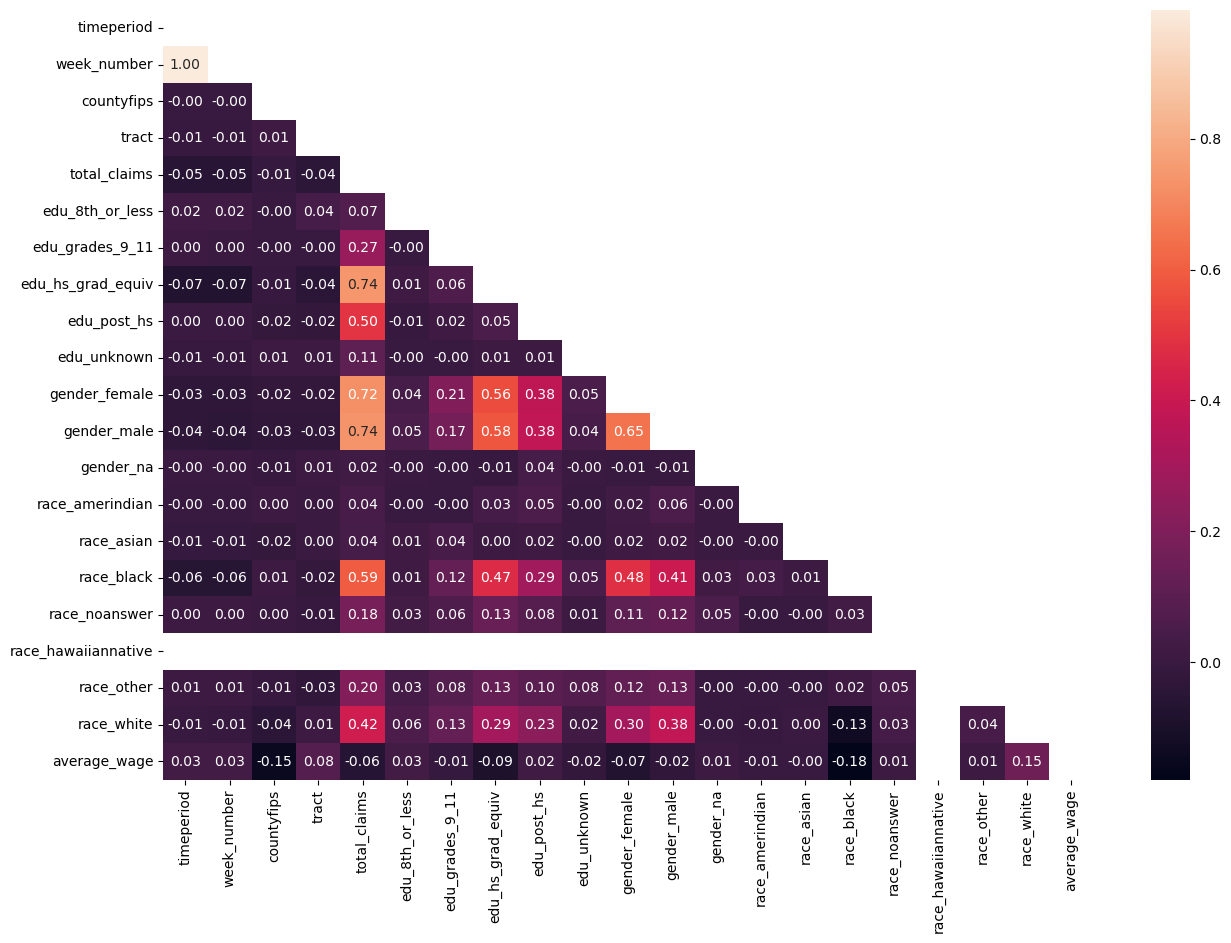

In [24]:
# check correlation again for new, merged frame
#correlation = main_df.corr()
#mask = np.triu(np.ones_like(correlation, dtype=bool))
#plt.figure(figsize=(15,10))
#sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [25]:
#main_df.isnull().sum()

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
average_wage              0
dtype: int64

In [ ]:
# main df analytics
#main_df.describe()

In [ ]:
#main_df.columns

In [ ]:
#timeline = main_df.groupby('week_number', as_index=False)['total_claims'].sum()

In [ ]:
#timeline

In [ ]:
# total claims over each week
#plt.figure(figsize=(15,10))
#sns.barplot(data=timeline, x = 'week_number', y = 'total_claims')

In [ ]:
# race demographics
#race_demographics = main_df.groupby(['week_number'], as_index=False)['race_amerindian','race_asian','race_black','race_noanswer','race_hawaiiannative','race_other','race_white','total_claims'].sum()

In [ ]:
#plt.figure(figsize=(15,10))
#sns.barplot(race_demographics, x= 'week_number', y='race_amerindian')

In [ ]:
#plt.figure(figsize=(15,10))
#sns.barplot(race_demographics, x= 'week_number', y='race_asian')

In [ ]:
#plt.figure(figsize=(15,10))
#sns.barplot(race_demographics, x= 'week_number', y='race_black')

In [ ]:
#plt.figure(figsize=(15,10))
#sns.barplot(race_demographics, x= 'week_number', y='race_noanswer')

In [ ]:
#plt.figure(figsize=(15,10))
#sns.barplot(race_demographics, x= 'week_number', y='race_hawaiiannative')

In [ ]:
#plt.figure(figsize=(15,10))
#sns.barplot(race_demographics, x= 'week_number', y='race_other')

In [ ]:
#plt.figure(figsize=(15,10))
#sns.barplot(race_demographics, x= 'week_number', y='race_white')

In [ ]:
# gender demographics
#gender_demographics = main_df.groupby(['week_number'], as_index=False)['gender_female', 'gender_male', 'gender_na','total_claims'].sum()

In [ ]:
# lets try a different plot method, seaborn is nice but strict in format
#gender_demographics.plot(x='week_number', y=['gender_female','gender_male','gender_na'], kind='bar', figsize=(20,10))
#plt.xlabel('week_number')
#plt.ylabel('gender_sums')
#plt.title('Recorded Gender Sum')
#plt.xticks(rotation=30, horizontalalignment='center')

In [ ]:
# education?
#edu_hist = main_df.groupby(['week_number'], as_index=False)['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',].sum()

In [ ]:
#edu_hist.plot(x='week_number', y=['edu_8th_or_less','edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown'], kind='bar', figsize=(20,10))
#plt.xlabel('week_number')
#plt.ylabel('education_sums')
#plt.title('Recorded Education Sum')
#plt.xticks(rotation=30, horizontalalignment='center')

### General impressions
From the correlation matrix, there's more than a few positive correlations with the target variable - but dropping these might remove essential information. While they are not "strongly" correlated, they do tell us that there are relationships between education and race when it comes to unemployment. The only exceptions are the gender variables for male and female. 

There also appears to be a spike in total claims during the last few weeks (aggregated by sum). 

If we look at race demographics, considering that this is survey data - there are more respondents that are either black or white compared to others, such as Indian-Americans, Asians, Hawaiian Natives, or other races. This however, does not mean that each respondent in this dataset has filed an unemployment claim. 

There are also more males than female respondents within this dataset, though this is unlikely to have an effect on the data on the whole.

Most respondents also appear to have a GED equivalent - followed by post HS education.

## Models
Since this is a regression task, I'll start with SVM and Random Forests. I will not be using Perceptrons or Neural Nets for this problem.

In [39]:
#prediction_list.to_csv('prediction_list.csv', index=False)

In [2]:
prediction_list = pd.read_csv('prediction_list.csv', index_col=0)
prediction_list.head(5)

uu_id  week_number
0  5bf51fc2e162d6faf9e3cf79e4198378           44
1  420b44cc7e3f55d738df565421e59941           44
2  e39c66ecceec76ee8f9f811fa4a2d246           44
3  a90462cd11ae4e43144239bf7c4828a4           44
4  8b20a6749088c7ff1237983076ebfeaa           44

In [3]:
def evaluate_regressor(prediction_dataframe):
    # Takes in a prediction dataframe of 2 columns, Actual values and Predicted values generated by a regressor
    # Outputs MSE, MAR, RMSE and MAPE metrics. Must have columns named Actual and Predicted.
    print('MSE:', mean_squared_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted']))
    print('MAE:', mean_absolute_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted']))
    print('RMSE:', np.sqrt(mean_squared_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted'])))
    print('MAPE:', np.mean(np.abs((prediction_dataframe['Actual'] - prediction_dataframe['Predicted']) / prediction_dataframe['Actual'])) * 100)

In [55]:
def get_predictions(regressor, model_type, name, week):
    # generates predictions for any model and writes out a dataframe in csv containing them
    # takes a regressor and learning method type as input: DL and ML
    # DL/ML variable basically changes the shape for an input from a 2D array to 3D arry, as required tensor shape
    result_list = []
    uu_id_transform = LE.fit_transform(prediction_list['uu_id'])
    if model_type == 'DL':
        predict_arr = np.array(SC_other.transform([[0, 1, 6, 4, 4, 5, 0, 1, 2, 0, 4, 1, 4200.0]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, week, axis=1)
            to_predict = np.reshape(to_predict, (to_predict.shape[0], to_predict.shape[1],1))
            r = regressor.predict(to_predict)
            result_list.append(r)
        result_list = np.array(result_list)
        result_list = np.reshape(result_list, (525,))
    elif model_type == 'ML':
        predict_arr = np.array(RB_other.transform([[0, 1, 6, 4, 4, 5, 0, 1, 2, 0, 4, 1, 4200.0]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, week, axis=1)
            r = regressor.predict(to_predict)
            result_list.append(r)
    result_df = pd.DataFrame(result_list, columns = ['Predictions'])
    prediction_sub = prediction_list.copy()
    prediction_sub['total_claims'] = result_df.values
    prediction_sub = prediction_sub[['uu_id','total_claims','week_number']]
    #os.makedirs('lost+found/submission_files', exist_ok=True)
    prediction_sub.to_csv(name+'.csv', index=False)
    return prediction_sub

In [5]:
def get_pred_frame(test_frame, prediction_array):
    prediction_frame = pd.DataFrame({'Actual': test_frame, 'Predicted': prediction_array.flatten()})
    return prediction_frame

In [6]:
# outlier detetion and handling - Inter Quartile Range Approach
def clearOutlier_IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    no_outliers = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    print(no_outliers.shape)
    return no_outliers

In [7]:
# outlier detection and handling - Z Score (gaussian only)
def clearOutlier_ZScore(data, threshold):
    zscore = np.abs(stats.zscore(data))
    thresh = threshold
    no_outliers = data[(zscore < thresh).all(axis=1)]
    return no_outliers

In [8]:
# outlier detection - automatic
def IsoForest_anomaly(data):
    IFO = IsolationForest(random_state=69)
    col_list = ['week_number', 'total_claims', 'edu_8th_or_less',
                'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female',
                'gender_male', 'race_amerindian', 'race_asian', 'race_black',
                'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
    NO_df = data.copy()
    IFO.fit(data)
    NO_df['anomaly_scores'] = IFO.decision_function(data)
    NO_df['anomaly'] = IFO.predict(data)
    no_outlier = NO_df[NO_df['anomaly'] == 1]
    print('Removed ', NO_df[NO_df['anomaly'] == -1].shape[0], 'datapoints')
    palette = ['#ff7f0e','#1f77b4']
    sns.pairplot(NO_df, vars = col_list, hue='anomaly', palette=palette)
    no_outlier.drop(['anomaly_scores','anomaly'], axis = 1, inplace=True)
    return no_outlier

In [9]:
def preprocess(data, scaling):
    no_outlierDF = ingest.copy()
    to_drop = ['timeperiod','tract','top_category_employer1','top_category_employer2',
           'top_category_employer3','tract_name','countyfips', 'edu_unknown', 'gender_na', 
           'race_noanswer']
    to_scale = ['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 
            'gender_female', 'gender_male', 'race_amerindian', 'race_asian', 'race_black', 
            'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
    no_outlierDF.drop(to_drop, axis=1, inplace=True)
    no_outlierDF['uu_id'] = LE.fit_transform(no_outlierDF['uu_id'])
    if scaling == 'Robust':
        no_outlierDF[to_scale] = RB_other.fit_transform(no_outlierDF[to_scale])
    elif scaling == 'Standard':
        no_outlierDF[to_scale] = SC_other.fit_transform(no_outlierDF[to_scale])
    return no_outlierDF

In [ ]:
# data specifically for models to ingest
# ingest = main_df.copy()

In [ ]:
# get old data for previous week saved in env
# old_ingest = pd.read_csv('lost+found/submission_files/ingest.csv', index_col=0)
# concat to form a single dataset
# merged_ingest = pd.concat([old_ingest, ingest])
# add new data
# combined_ingest = pd.read_csv('lost+found/submission_files/combined_ingest.csv')

In [10]:
# updated_ingest = pd.concat([merged_ingest, combined_ingest])
ingest = pd.read_csv('complete_ingest.csv')

In [32]:
#new_data = main_df.copy()
#complete_ingest = pd.concat([ingest, new_data])
#complete_ingest.shape

(86645, 26)

In [11]:
ingest.isnull().sum()

uu_id                       0
timeperiod                  0
week_number                 0
countyfips                  0
tract                       0
tract_name                  0
total_claims                0
edu_8th_or_less             0
edu_grades_9_11             0
edu_hs_grad_equiv           0
edu_post_hs                 0
edu_unknown                 0
top_category_employer1      0
top_category_employer2     49
top_category_employer3    274
gender_female               0
gender_male                 0
gender_na                   0
race_amerindian             0
race_asian                  0
race_black                  0
race_noanswer               0
race_hawaiiannative         0
race_other                  0
race_white                  0
average_wage                0
dtype: int64

In [12]:
ingest.dropna(axis=0, inplace=True)

In [13]:
ingest.shape

(86124, 26)

In [37]:
# check if new data is duplicate
#complete_ingest.equals(main_df)

False

In [38]:
## write out combined data for use later
#os.makedirs('lost+found/submission_files', exist_ok=True)
#complete_ingest.to_csv('lost+found/submission_files/complete_ingest.csv', index=False)

In [ ]:
# shuffle the data - is this really necessary?
# merged_ingest = merged_ingest.sample(frac=1)

In [14]:
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
LE = LabelEncoder()
RB_other = RobustScaler()
SC_other = StandardScaler()
# RB_claims = RobustScaler()

In [15]:
# copy set, for use in ML outlier detection
ML_data = preprocess(ingest, 'Robust')

Removed  9578 datapoints


C:\Users\ldmag\AppData\Local\Temp\ipykernel_25160\896955743.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outlier.drop(['anomaly_scores','anomaly'], axis = 1, inplace=True)


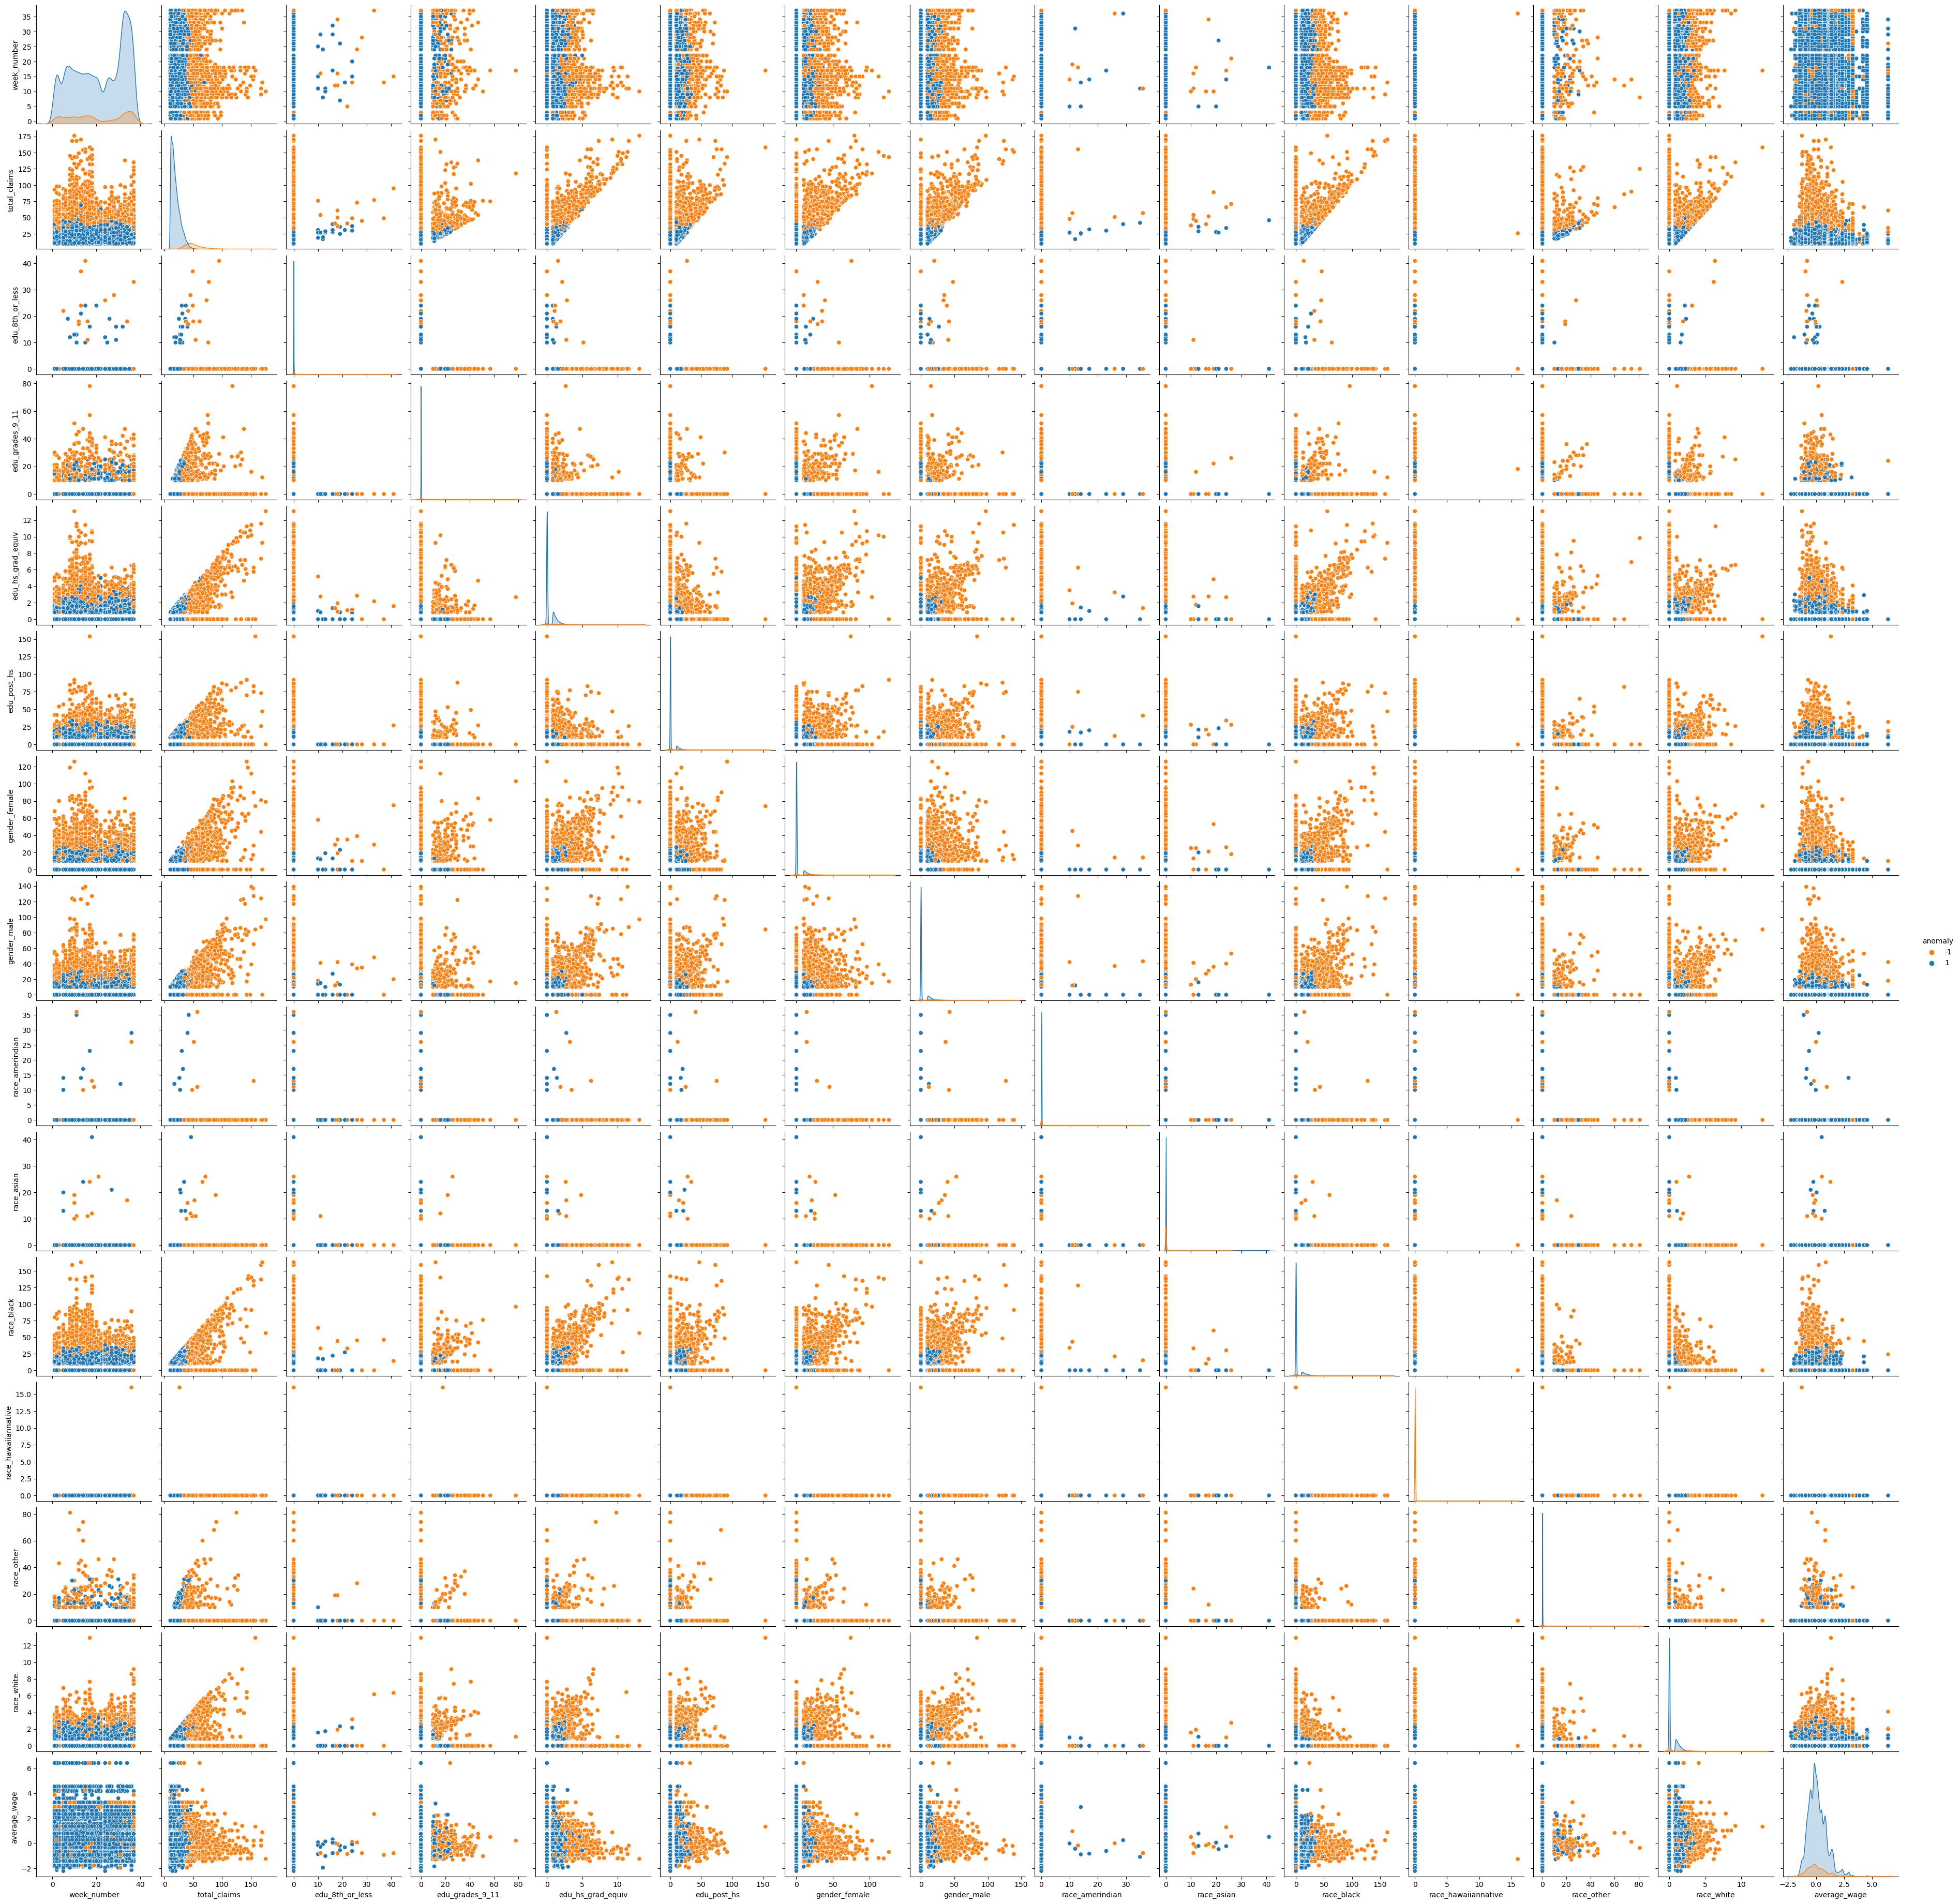

In [18]:
ingest_clean = IsoForest_anomaly(ML_data)

In [19]:
# set target and preprocess again
#to_drop = ['timeperiod','tract','total_claims','top_category_employer1','top_category_employer2','top_category_employer3','tract_name','countyfips', 'edu_unknown', 'gender_na', 'race_noanswer']
Y = ingest_clean['total_claims']
X = ingest_clean[['uu_id', 'week_number', 'edu_8th_or_less',
                 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female',
                 'gender_male', 'race_amerindian', 'race_asian', 'race_black',
                 'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
#X['uu_id'] = LE.fit_transform(X['uu_id'])
#to_scale = ['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female', 'gender_male', 
#            'race_amerindian', 'race_asian', 'race_black', 'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
#X[to_scale] = RB_other.fit_transform(X[to_scale])
#X[['total_claims']] = RB_claims.fit_transform(main_df[['total_claims']])

In [20]:
# import
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=69)

### SVR

Note: Removed Grid Search code because the last 3 runs on the fit cell took 8 hours. Assumping lack of compute since this runs well locally.

Supervised Learning algorithm from sklearn library used for regression, hence the name Support Vector Regression (SVR). Combined with robust pre-processing - offers robust predictions and is best used with Grid Search. The algorithm was designed initally with Classification tasks in mind but has been extended for Regression tasks in 1996. The intuition of the algorthm is basically to mimimize the error between datapoints using Ordinary Least Squares - but the Regression algorithm uses an Epsilon insensitive tube to determine a margin of error, in order to determine the line of best fit. 

Programmatically, the most important variables within this package/algorithm are the Gamma and C values, which it is best used with a Grid Search or Randomized CV Search, which makes it computationally expensive. If the parameters are set correctly, we can expect accurate results. 

In [ ]:
'''
Regressor_SVR = SVR(kernel ='rbf')
Regressor_SVR.fit(X_train, Y_train)

Y_pred_SVR = Regressor_SVR.predict(X_test).reshape(-1,1)

# evaluate performance
prediction_frame_SVR = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_SVR.flatten()})
prediction_frame_SVR

evaluate_regressor(prediction_frame_SVR)

# what about actual test table?
prediction_list

%%capture
result_list = []
uu_id_transform = LE.fit_transform(prediction_list['uu_id'])
for val in uu_id_transform:
    r = Regressor_SVR.predict([[val, 40, 0.045797, 0.400110, 0.543421, 3.040176, 3.970520, 4.324695, 0.018785, 0.008501, 4.227890, 0.0, 0.217606, 0.517311, 0.106434]])
    result_list.append(r)

# to make things easier, I will be making predictions based on mean of each variable values

result_df = pd.DataFrame(result_list, columns = ['Predictions'])
result_df

prediction_sub = prediction_list.copy()

prediction_sub['total_claims'] = result_df.values
prediction_sub = prediction_sub[['uu_id','total_claims','week_number']]

# write out submission file
#os.makedirs('lost+found/submission_files', exist_ok=True)
#prediction_sub.to_csv('lost+found/submission_files/submission_prediction_output.csv')
'''

### Random Forests with Grid Search
#### WARNING: *RUNNING  THE  CELL  BELOW  IS  TIME  AND  COMPUTE  INTENSIVE*

In [33]:
'''
%%capture

from sklearn.ensemble import RandomForestRegressor
Regressor_RF = RandomForestRegressor(random_state=69)
search_space = dict()
search_space['n_estimators'] = np.arange(400,700,100)
search_space['criterion'] = ['squared_error','absolute_error']
search_space['max_features'] = ['sqrt',1.0]
GS = GridSearchCV(estimator=Regressor_RF, param_grid=search_space, cv=3, n_jobs=-1, return_train_score=True)

result = GS.fit(X_train,Y_train)

# running this locally
# local parameter results
# {'criterion': 'squared_error', 'max_features': 1.0, 'n_estimators': 600}
# 0.9262734740323463 - score
'''

In [34]:
# result.best_params_

{'criterion': 'squared_error', 'max_features': 1.0, 'n_estimators': 600}

In [21]:
Regressor_RF_bestFit = RandomForestRegressor(random_state=69, criterion='squared_error', max_features=1.0, n_estimators= 600)
Regressor_RF_bestFit.fit(X_train.values, Y_train.values)

RandomForestRegressor(n_estimators=600, random_state=69)

In [22]:
Y_pred_RFR = Regressor_RF_bestFit.predict(X_test.values).reshape(-1,1)

In [24]:
get_pred_frame(Y_test, Y_pred_RFR)

Actual  Predicted
8024       13  12.963333
27301      11  11.033333
20306      22  21.686667
56657      11  11.000000
9686       32  32.038333
...       ...        ...
71715      20  20.005000
60119      25  25.000000
24994      19  19.013333
59904      18  18.213333
21017      20  20.000000

[15310 rows x 2 columns]

In [25]:
# evaluate
evaluate_regressor(get_pred_frame(Y_test, Y_pred_RFR))

MSE: 1.0144532393497352
MAE: 0.3057618114522099
RMSE: 1.0072006946729808
MAPE: 1.907274160611874


In [26]:
# save model
joblib.dump(Regressor_RF_bestFit, 'RF_v1-7.pkl')

['RF_v1-7.pkl']

In [56]:
# call func
get_predictions(Regressor_RF_bestFit, 'ML', 'submission_prediction_output_RFR', 44)

D:\Anaconda\envs\MDL\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


uu_id  total_claims  week_number
0    5bf51fc2e162d6faf9e3cf79e4198378     19.111667           44
1    420b44cc7e3f55d738df565421e59941     19.845000           44
2    e39c66ecceec76ee8f9f811fa4a2d246     17.976667           44
3    a90462cd11ae4e43144239bf7c4828a4     18.146667           44
4    8b20a6749088c7ff1237983076ebfeaa     18.215000           44
..                                ...           ...          ...
520  46c4f6c75e663b1ca82ea7994e6d83d3     19.553333           44
521  1deebda501712e7595b531b8337bc31a     19.430000           44
522  5a9758f65f001b6432ff31ff64a459d7     19.145000           44
523  e8b3b95e93a6dc7dbb90f4e72e7ac065     18.753333           44
524  932a58530abff8a48558e2a15639d453     18.130000           44

[525 rows x 3 columns]

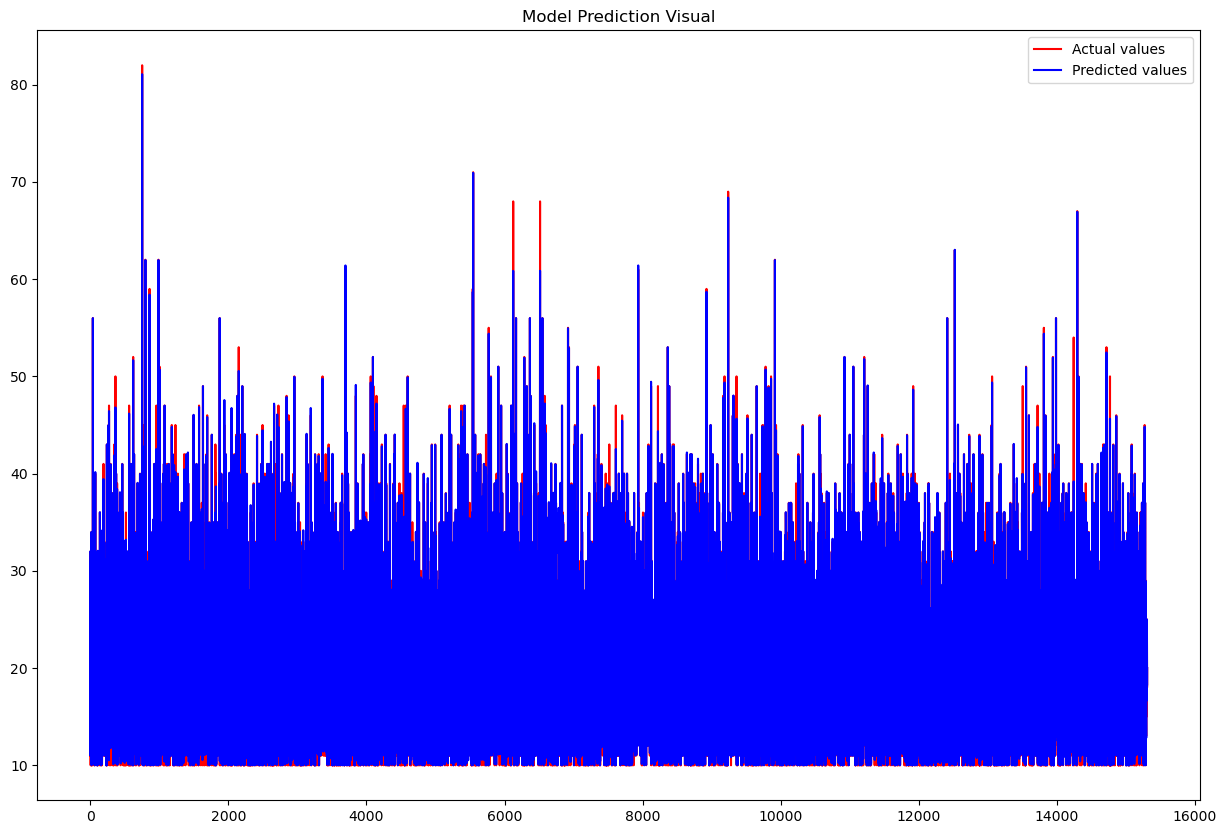

In [27]:
plt.figure(figsize=(15,10))
plt.plot(Y_test.values, color = 'red', label = 'Actual values')
plt.plot(Y_pred_RFR, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()

### Bayesian Ridge Regression

In [ ]:
'''
# attempting unoptimized model to test 
Regressor_BR = BayesianRidge()
Regressor_BR.fit(X_train, Y_train)

Y_pred_BR = Regressor_BR.predict(X_test).reshape(-1,1)
prediction_frame_BR = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_BR.flatten()})
prediction_frame_BR

evaluate_regressor(prediction_frame_BR)
'''

From metrics, this is only slightly better than the SVR but not as good as the RFR model. From sklearn documentation, optimizing with Randomized Search or Grid Search may be too computationally expensive as there are too many parameters to account for. 

Not to mention my inexperience with this specific model.

### Lasso Regression with Repeated K Fold

- Removed Grid Search as the CV class is more effective due to inbuilt alpha search

In [ ]:
'''
cross_valK_Lasso = RepeatedKFold(n_splits=5, n_repeats=3, random_state=69)
Regressor_Lasso = LassoCV(alphas= np.arange(0,1,0.01), cv = cross_valK_Lasso, random_state = 69, n_jobs=-1)

%%capture
Regressor_Lasso.fit(X_train, Y_train)

# capture because of convergence warnings

Y_pred_Lasso = Regressor_Lasso.predict(X_test).reshape(-1,1)

prediction_frame_Lasso = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_Lasso.flatten()})
prediction_frame_Lasso

# evaluate
evaluate_regressor(prediction_frame_Lasso)
'''

Same results; more or less - as the Bayesian Ridge Model. Try something else.

### Elastic Net with Repeated K Fold
#### WARNING: Fit cell takes 1 hour to run

In [ ]:
'''
cross_valK_ENet = RepeatedKFold(n_splits=5, n_repeats=3, random_state=69)
ENet = ElasticNetCV(l1_ratio=np.arange(0.1,1,0.01), cv=cross_valK_ENet, n_jobs=-1)

%%capture
ENet.fit(X_train, Y_train)

Y_pred_ENet = ENet.predict(X_test).reshape(-1,1)

prediction_frame_ENet = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_ENet.flatten()})

evaluate_regressor(prediction_frame_ENet)
'''

## Deep Learning Section: ENTER AT OWN RISK

### Forward fed stacked LSTM with linear transformation

In [28]:
# this needs different feature engineering, so I'm starting from scratch
DL_data = preprocess(ingest, 'Standard')

In [29]:
DL_data.columns

Index(['uu_id', 'week_number', 'total_claims', 'edu_8th_or_less',
       'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female',
       'gender_male', 'race_amerindian', 'race_asian', 'race_black',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage'],
      dtype='object')

Removed  9578 datapoints


C:\Users\ldmag\AppData\Local\Temp\ipykernel_25160\896955743.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outlier.drop(['anomaly_scores','anomaly'], axis = 1, inplace=True)


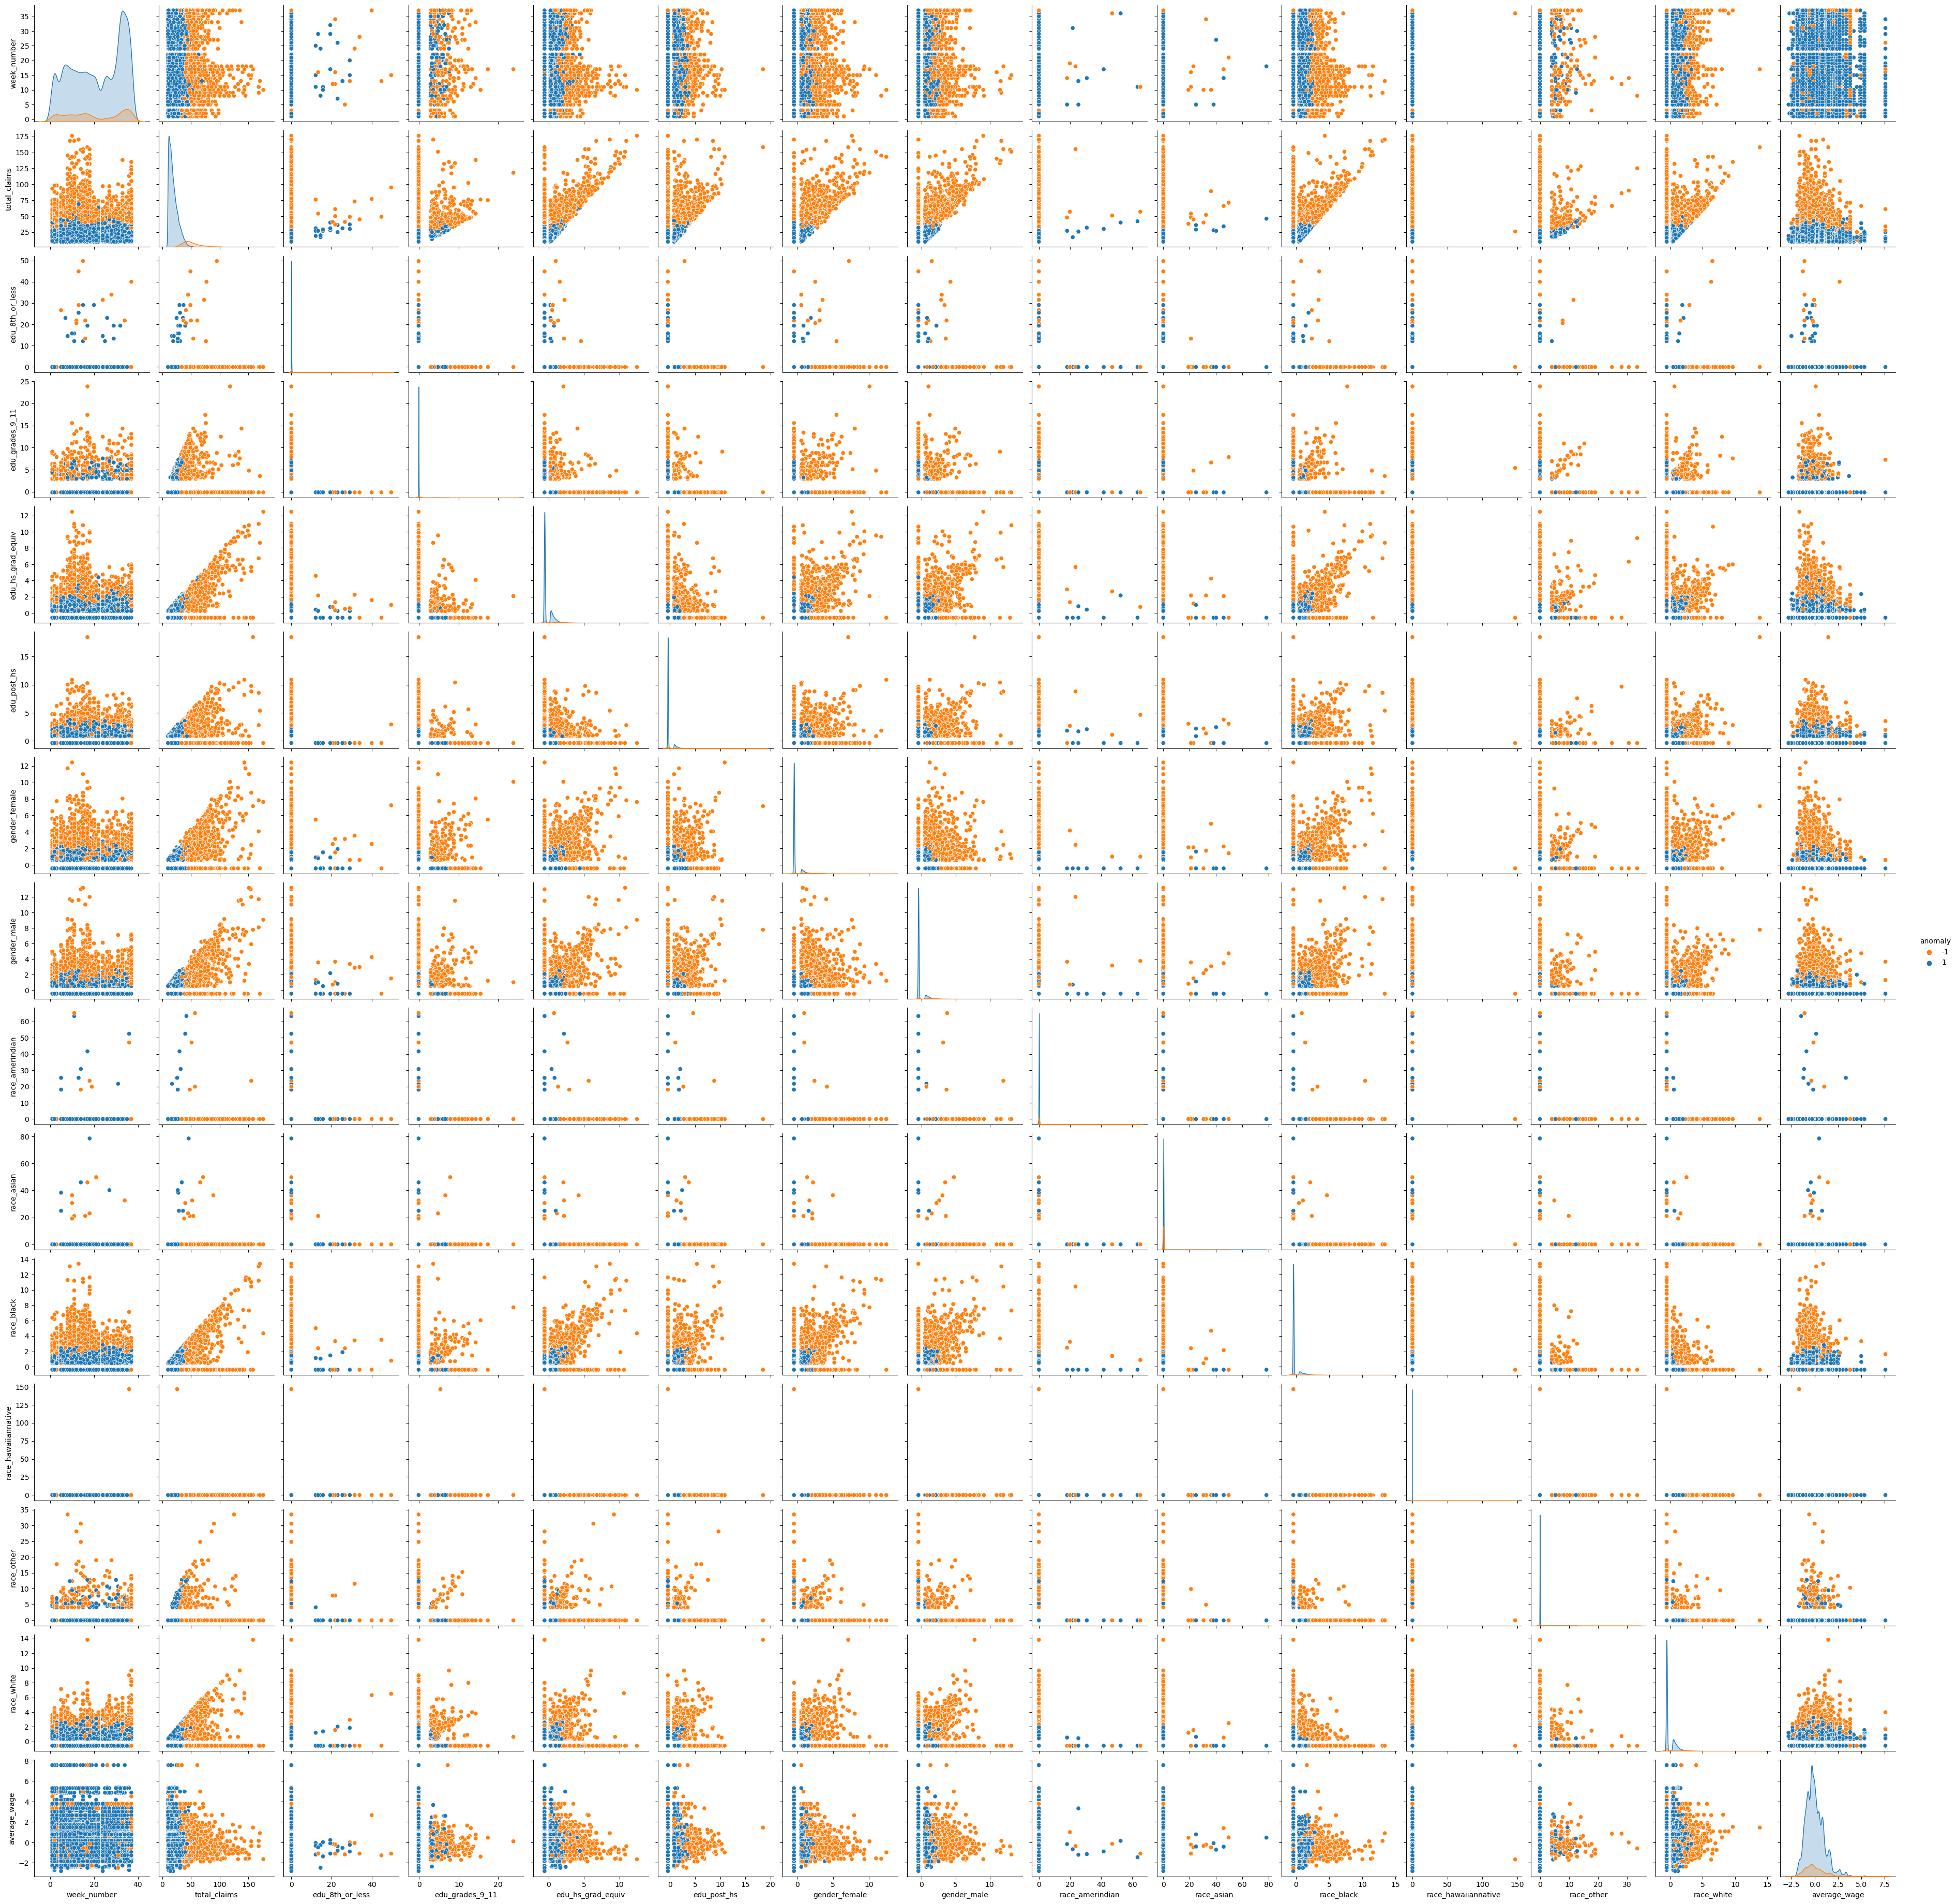

In [30]:
DL_ingest = IsoForest_anomaly(DL_data)

In [31]:
DL_ingest.shape

(76546, 16)

In [33]:
# split set
DL_Y = DL_ingest['total_claims']
DL_X = DL_ingest[['uu_id', 'week_number', 'edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female', 'gender_male',
               'race_amerindian', 'race_asian', 'race_black', 'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
DL_XTrain, DL_XTest, DL_YTrain, DL_YTest = train_test_split(DL_X, DL_Y, test_size=0.20, random_state=69)

In [34]:
# change to np vectors
DL_XTrain = DL_XTrain.to_numpy()
DL_XTest = DL_XTest.to_numpy()

In [35]:
# reshape because F*** tensors
DL_XTrain = np.reshape(DL_XTrain, (DL_XTrain.shape[0], DL_XTrain.shape[1], 1))

In [36]:
# convert X and Y train to float because input dtype accepts floats only
DL_YTrain = DL_YTrain.astype(float)
DL_XTrain = DL_XTrain.astype(float)

In [ ]:
'''
# start preparing to suffer: Model creation
LSTM_regressor = Sequential()
LSTM_regressor.add(LSTM(units=50, return_sequences=True, input_shape= (DL_XTrain.shape[1], 1)))
LSTM_regressor.add(Dropout(0.2))
LSTM_regressor.add(LSTM(units=50, return_sequences=True))
LSTM_regressor.add(Dropout(0.2))
LSTM_regressor.add(LSTM(units=50, return_sequences=True))
LSTM_regressor.add(Dropout(0.2))
LSTM_regressor.add(LSTM(units=50, return_sequences=False))
LSTM_regressor.add(Dropout(0.2))
LSTM_regressor.add(Dense(units=1))

# compile
LSTM_regressor.compile(optimizer='adam', loss='mean_squared_error')

# fit - pray to the Omnissiah
LSTM_regressor.fit(DL_XTrain, DL_YTrain, epochs=100, batch_size=50)

# change type and rehspe test sets
DL_XTest = DL_XTest.astype(float)

DL_XTest = np.reshape(DL_XTest, (DL_XTest.shape[0], DL_XTest.shape[1],1))
predictions = LSTM_regressor.predict(DL_XTest)

get_pred_frame(DL_YTest, predictions)

evaluate_regressor(get_pred_frame(DL_YTest, predictions))
'''

In [ ]:
'''
plt.figure(figsize=(15,10))
plt.plot(DL_YTest.values, color = 'red', label = 'Actual values')
plt.plot(predictions, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()
'''

In [ ]:
#get_predictions(LSTM_regressor, 'DL')

### Birectional Stacked LSTM with non-linear transformations: *Test*

In [37]:
StackLSTM_Regressor = Sequential()
StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape = (DL_XTrain.shape[1], 1))))
StackLSTM_Regressor.add(Dropout(0.2))
StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
StackLSTM_Regressor.add(Dropout(0.2))
StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=False)))
StackLSTM_Regressor.add(Dropout(0.2))
#StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
#StackLSTM_Regressor.add(Dropout(0.2))
#StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=False)))
#StackLSTM_Regressor.add(Dropout(0.2))
StackLSTM_Regressor.add(Dense(units=1, activation='relu'))

In [38]:
StackLSTM_Regressor.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
StackLSTM_Regressor.fit(DL_XTrain, DL_YTrain, epochs=450, batch_size=72)

Epoch 1/450
851/851 [==============================] - 33s 26ms/step - loss: 44.6075
Epoch 2/450
851/851 [==============================] - 24s 28ms/step - loss: 18.9215
Epoch 3/450
851/851 [==============================] - 24s 28ms/step - loss: 16.9069
Epoch 4/450
851/851 [==============================] - 27s 31ms/step - loss: 15.9248
Epoch 5/450
851/851 [==============================] - 26s 31ms/step - loss: 15.2748
Epoch 6/450
851/851 [==============================] - 26s 31ms/step - loss: 14.8637
Epoch 7/450
851/851 [==============================] - 26s 31ms/step - loss: 14.5868
Epoch 8/450
851/851 [==============================] - 25s 29ms/step - loss: 14.4372
Epoch 9/450
851/851 [==============================] - 26s 30ms/step - loss: 14.1567
Epoch 10/450
851/851 [==============================] - 26s 30ms/step - loss: 13.9823
Epoch 11/450
851/851 [==============================] - 27s 31ms/step - loss: 13.8931
Epoch 12/450
851/851 [==============================] - 28s 33m

851/851 [==============================] - 28s 33ms/step - loss: 10.5226
Epoch 97/450
851/851 [==============================] - 27s 32ms/step - loss: 10.5266
Epoch 100/450
851/851 [==============================] - 27s 32ms/step - loss: 10.3645
Epoch 101/450
851/851 [==============================] - 27s 31ms/step - loss: 10.2937
Epoch 102/450
851/851 [==============================] - 26s 31ms/step - loss: 10.4585
Epoch 103/450
851/851 [==============================] - 27s 32ms/step - loss: 10.3748
Epoch 104/450
851/851 [==============================] - 27s 31ms/step - loss: 9.9472
Epoch 121/450
851/851 [==============================] - 26s 30ms/step - loss: 9.9817
Epoch 122/450
851/851 [==============================] - 26s 30ms/step - loss: 9.8567
Epoch 123/450
851/851 [==============================] - 26s 30ms/step - loss: 9.9153
Epoch 124/450
851/851 [==============================] - 26s 30ms/step - loss: 9.6039
Epoch 132/450
851/851 [==============================] - 26s 30

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



851/851 [==============================] - 28s 32ms/step - loss: 8.8315
Epoch 252/450
851/851 [==============================] - 27s 32ms/step - loss: 7.9704
Epoch 253/450
851/851 [==============================] - 27s 32ms/step - loss: 8.2413
Epoch 254/450
851/851 [==============================] - 26s 30ms/step - loss: 8.4359
Epoch 255/450
851/851 [==============================] - 26s 30ms/step - loss: 8.1830
Epoch 256/450
851/851 [==============================] - 26s 30ms/step - loss: 8.3002
Epoch 257/450
851/851 [==============================] - 25s 30ms/step - loss: 9.0022
Epoch 258/450
851/851 [==============================] - 26s 30ms/step - loss: 8.5789
Epoch 259/450
851/851 [==============================] - 25s 30ms/step - loss: 8.6295
Epoch 260/450
851/851 [==============================] - 26s 30ms/step - loss: 8.1911
Epoch 261/450
851/851 [==============================] - 26s 31ms/step - loss: 8.2364
Epoch 262/450
851/851 [==============================] - 26s 31ms/st

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



851/851 [==============================] - 27s 32ms/step - loss: 8.3381
Epoch 342/450
851/851 [==============================] - 27s 31ms/step - loss: 7.7965
Epoch 343/450
851/851 [==============================] - 26s 30ms/step - loss: 7.6111
Epoch 344/450
851/851 [==============================] - 26s 30ms/step - loss: 7.8038
Epoch 345/450
851/851 [==============================] - 26s 30ms/step - loss: 7.8991
Epoch 346/450
851/851 [==============================] - 26s 30ms/step - loss: 8.0644
Epoch 347/450
851/851 [==============================] - 26s 30ms/step - loss: 7.7163
Epoch 348/450
851/851 [==============================] - 25s 30ms/step - loss: 9.5876
Epoch 349/450
851/851 [==============================] - 26s 30ms/step - loss: 7.7915
Epoch 350/450
851/851 [==============================] - 26s 31ms/step - loss: 8.0986
Epoch 363/450
851/851 [==============================] - 26s 30ms/step - loss: 8.3142
Epoch 364/450
851/851 [==============================] - 26s 30ms/st

In [40]:
# float cast
DL_XTest = DL_XTest.astype(float)
# make predictions
DL_XTest = np.reshape(DL_XTest, (DL_XTest.shape[0], DL_XTest.shape[1],1))
predictions = StackLSTM_Regressor.predict(DL_XTest)

479/479 [==============================] - 5s 6ms/step


In [41]:
get_pred_frame(DL_YTest, predictions)

Actual  Predicted
8024       13  13.074990
27301      11  15.815273
20306      22  19.076248
56657      11  11.222521
9686       32  31.825665
...       ...        ...
71715      20  17.726391
60119      25  24.566885
24994      19  18.236702
59904      18  19.424572
21017      20  16.860382

[15310 rows x 2 columns]

In [42]:
evaluate_regressor(get_pred_frame(DL_YTest, predictions))

MSE: 7.273540016574371
MAE: 1.409722914343796
RMSE: 2.696950132385538
MAPE: 8.896553477675196


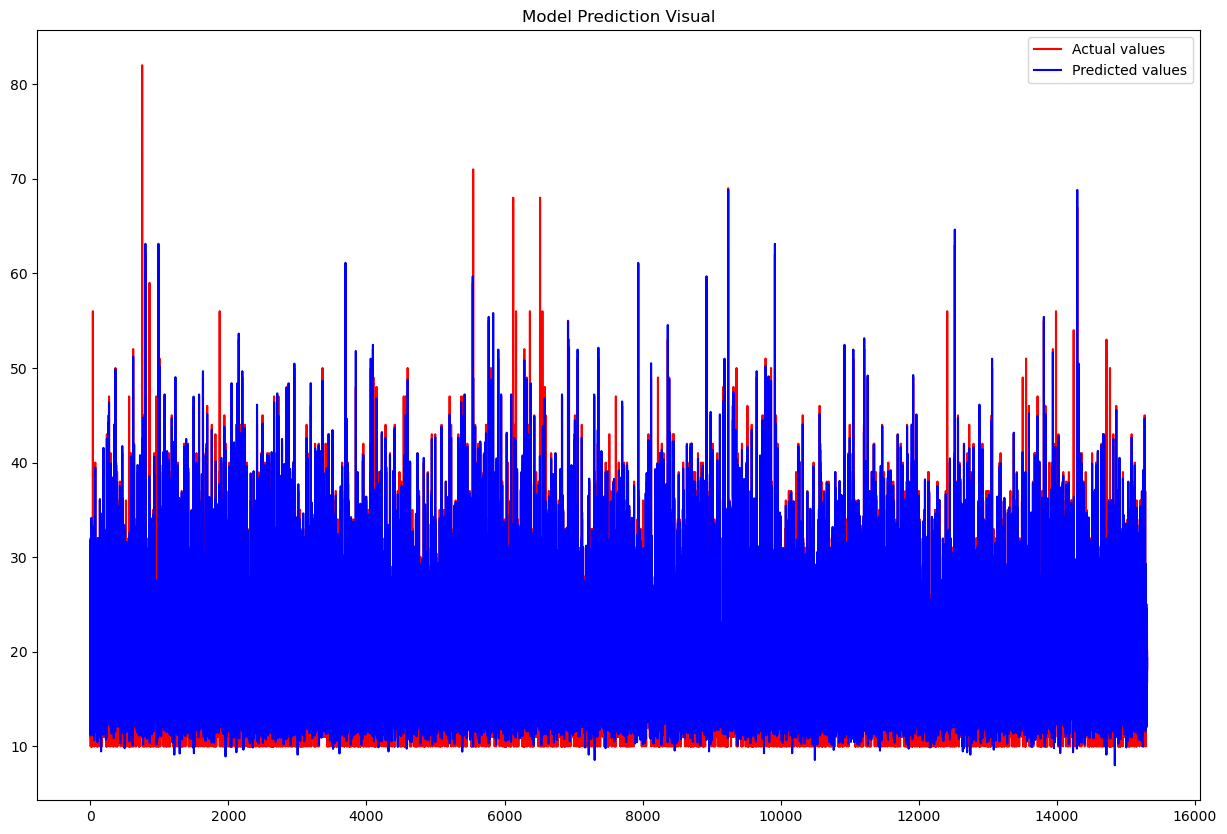

In [43]:
plt.figure(figsize=(15,10))
plt.plot(DL_YTest.values, color = 'red', label = 'Actual values')
plt.plot(predictions, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()

In [57]:
get_predictions(StackLSTM_Regressor, 'DL', 'submission_prediction_output', 44)

1/1 [==============================] - ETA: 0s

D:\Anaconda\envs\MDL\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


uu_id  total_claims  week_number
0    5bf51fc2e162d6faf9e3cf79e4198378     31.692566           44
1    420b44cc7e3f55d738df565421e59941     31.945038           44
2    e39c66ecceec76ee8f9f811fa4a2d246     32.517586           44
3    a90462cd11ae4e43144239bf7c4828a4     32.384647           44
4    8b20a6749088c7ff1237983076ebfeaa     32.378265           44
..                                ...           ...          ...
520  46c4f6c75e663b1ca82ea7994e6d83d3     31.946793           44
521  1deebda501712e7595b531b8337bc31a     31.585407           44
522  5a9758f65f001b6432ff31ff64a459d7     31.664272           44
523  e8b3b95e93a6dc7dbb90f4e72e7ac065     32.531639           44
524  932a58530abff8a48558e2a15639d453     32.378044           44

[525 rows x 3 columns]

Both LSTMs appear to be underfitting. It is likely that convergence will not be reached unless I use more epochs to train the model - however, due to the complexity of the algorithm - I estimate the time to train this model at approximately 1 day at maximum,
accounting for experimentation with activation function and epochs. Will improve on this model further on. 

In [44]:
# save model and weights
StackLSTM_Regressor.save('BiDLSTM_v1-05.h5')